In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, gumbel_r, weibull_max
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression

# 1. Load the data

In [156]:
file_path = 'BG_precip_hourly.xlsx'
df = pd.read_excel(file_path)
df.head()

,year,month,date,HRF01,HRF02,HRF03,HRF04,HRF05,HRF06,HRF07,...,HRF15,HRF16,HRF17,HRF18,HRF19,HRF20,HRF21,HRF22,HRF23,HRF24
0,1969,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1969,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1969,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1969,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1969,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate the percentage of missing data

In [157]:
null_cells = df.isnull().sum()
df_len = len(df)
null_percentages = null_cells / df_len * 100
print(f'Percentage of missing data = {round(null_percentages.mean(), 4)}%')


Percentage of missing data = 5.3427%


## Calculate basic statistics (e.g., mean, variance, L-skewness, etc.)
+ Mean (Average)
+ Variance
+ Standard Deviation
+ Median
+ Mode
+ Range
+ L-skewness
+ Kurtosis
+ Percentiles

In [158]:

mean = df.iloc[:, 3:].mean().mean()
variance = df.iloc[:, 3:].var().mean()
standard_deviation = df.iloc[:, 3:].std().mean()
median = df.iloc[:, 3:].median().median()
mode = df.iloc[:, 3:].mode().iloc[0].mode()
Range = df.iloc[:, 3:].max().max() - df.iloc[:, 3:].min().min()
skewness = df.iloc[:, 3:].skew().mean()
kurtosis = df.iloc[:, 3:].kurtosis().mean()
percentiles = df.iloc[:, 3:].quantile([0.25, 0.5, 0.75])
percentiles.rename(index={0.25: '25th', 0.5: '50th', 0.75: '75th'}, inplace=True)
percentiles.rename_axis('Percentiles', inplace=True)




print("Mean:", mean)
print("Variance:", variance)
print("Standard Deviation:", standard_deviation)
print("Median:", median)
print("Mode:", mode[0])
print("Range:", Range)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)
print("Percentiles:")
percentiles

Mean: 0.11200845449788693
Variance: 1.7062524222940343
Standard Deviation: 1.2246240873231085
Median: 0.0
Mode: 0.0
Range: 192.0
Skewness: 33.762985367258075
Kurtosis: 2078.244791711712
Percentiles:


,HRF01,HRF02,HRF03,HRF04,HRF05,HRF06,HRF07,HRF08,HRF09,HRF10,...,HRF15,HRF16,HRF17,HRF18,HRF19,HRF20,HRF21,HRF22,HRF23,HRF24
Percentiles,,,,,,,,,,,,,,,,,,,,,
25th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate probability dry

In [159]:
hrs_with_zero_precip = (df.iloc[:, 3:] == 0).sum().sum()
total_hours = df.shape[0] * 24

probability_dry = hrs_with_zero_precip / total_hours

print("Probability dry:", probability_dry)

Probability dry: 0.8972398237242171


## Plot the time series.

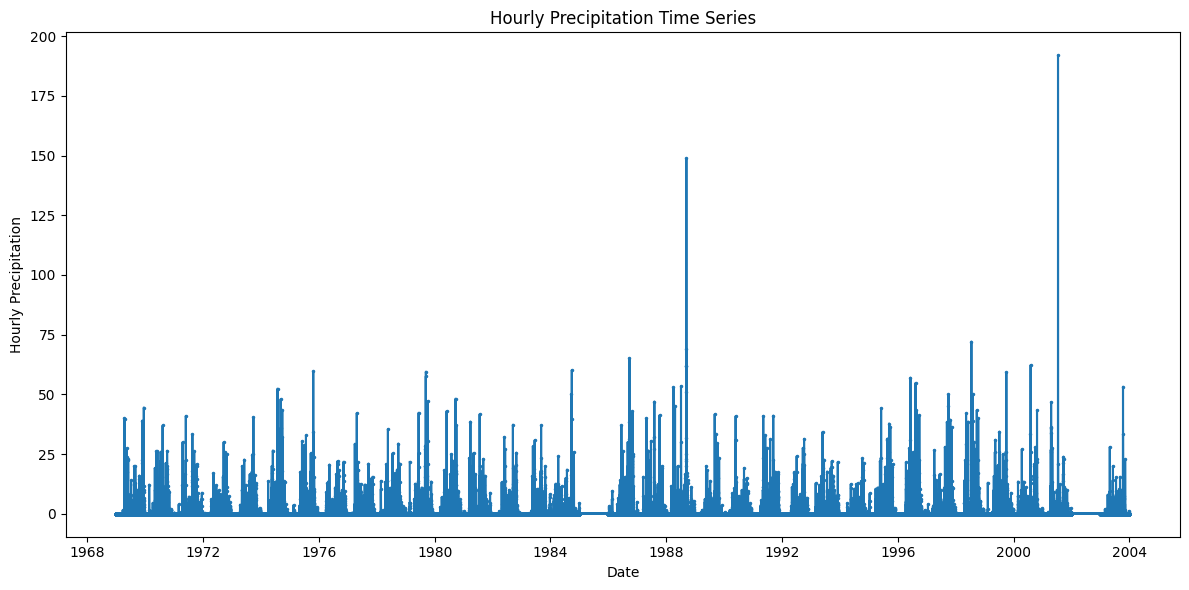

In [160]:
df.rename(columns={'date': 'day'}, inplace=True)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])


melted_df = pd.melt(df, id_vars=['datetime'], value_vars=df.columns[3:], var_name='hour', value_name='precipitation')


plt.figure(figsize=(12, 6))
plt.plot(melted_df['datetime'], melted_df['precipitation'], marker='.', linestyle='-', markersize=3)
plt.xlabel('Date')
plt.ylabel('Hourly Precipitation')
plt.title('Hourly Precipitation Time Series')
plt.tight_layout()
plt.show()



# 2. Calculate annual maxima series at an hourly scale

In [161]:
melted_df = pd.melt(df, id_vars=['datetime'], value_vars=df.columns[3:], var_name='hour', value_name='precipitation')


melted_df['year'] = melted_df['datetime'].dt.year
melted_df['hour'] = melted_df['hour'].str.extract('(\d+)').astype(int)

annual_maxima_series = melted_df.groupby(['year', 'hour'])['precipitation'].max()

print(annual_maxima_series.head(48))

year  hour
1969  1       17.7
      2       12.8
      3       12.0
      4        5.3
      5        6.1
      6        4.1
      7        2.1
      8        3.2
      9        1.8
      10       1.7
      11       1.1
      12       1.4
      13       3.8
      14      16.0
      15       5.0
      16      10.9
      17      12.0
      18      44.5
      19      23.6
      20      23.0
      21      14.5
      22      40.0
      23      22.6
      24      39.0
1970  1       18.9
      2       12.2
      3       26.4
      4        5.0
      5        9.3
      6        3.5
      7        4.1
      8        1.3
      9        0.3
      10       1.0
      11       2.0
      12       1.7
      13       1.4
      14      10.0
      15       6.6
      16       9.7
      17      26.3
      18      20.0
      19      22.2
      20      26.0
      21      37.0
      22      26.1
      23       5.5
      24      19.2
Name: precipitation, dtype: float64


# 3. Aggregate the hourly precipitation to 3-hr, 6-hr, 12-hr, 1-day, 7-day, and 15-day time scales and calculate basic statistics, probability dry, and annual maxima series at these scales. Comment on the changing statistics.

Each sub-question would be done in different steps:
+ Aggregate the hourly precipitation to 3-hr, 6-hr, 12-hr, 1-day, 7-day, and 15-day time scales
+ Calculate basic statistics at these time scales
+ Calculate probability dry at these time scales
+ Calculate annual maxima series at these scales
+ Comment on the changing statistics.

+ ## Aggregate the hourly precipitation to 3-hr, 6-hr, 12-hr, 1-day, 7-day, and 15-day time scales

In [162]:


melted_df = pd.melt(df, id_vars=['datetime'], value_vars=df.columns[3:], var_name='hour', value_name='precipitation')


time_scales = [3, 6, 12, 24, 7*24, 15*24] # hours in 3-hour, 6-hour, 12-hour, 1-day, 7-day, and 15-day
ts = '3-hour 6-hour 12-hour 1-day 7-day 15-day'.split()
ts_dict = dict(zip(time_scales, ts))
for scale in time_scales:
    melted_df[f'{scale}_hr_agg'] = melted_df['precipitation'].rolling(scale).sum()
    agg_col = f'{scale}_hr_agg'
    aggregated_series = melted_df[agg_col]

    
columns= dict(zip(['3_hr_agg', '6_hr_agg', '12_hr_agg', '24_hr_agg', '168_hr_agg', '360_hr_agg'],[f'{i} agg' for i in ts]))

df_with_hourly_aggregate = melted_df.rename(columns=columns)

df_with_hourly_aggregate

,datetime,hour,precipitation,3-hour agg,6-hour agg,12-hour agg,1-day agg,7-day agg,15-day agg
0,1969-01-01,HRF01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-01-02,HRF01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1969-01-03,HRF01,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1969-01-04,HRF01,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1969-01-05,HRF01,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
306787,2003-12-27,HRF24,0.0,0.0,0.0,0.0,0.0,9.1,16.4
306788,2003-12-28,HRF24,0.0,0.0,0.0,0.0,0.0,9.1,16.4
306789,2003-12-29,HRF24,0.0,0.0,0.0,0.0,0.0,9.1,16.4
306790,2003-12-30,HRF24,0.0,0.0,0.0,0.0,0.0,9.1,16.4


+ ## Calculate basic statistics at these time scales

In [163]:

time_scales = [3, 6, 12, 24, 7*24, 15*24]  # hours in 3-hour, 6-hour, 12-hour, 1-day, 7-day, and 15-day

for scale in time_scales:
    agg_col = f'{scale}_hr_agg'
    aggregated_series = melted_df[agg_col]
    percentile_index = {0.25: '25th percentile', 0.5: '50th percentile', 0.75: '75th percentile'}
    
    mean = aggregated_series.mean()
    variance = aggregated_series.var()
    std_deviation = aggregated_series.std()
    median = aggregated_series.median()
    mode_value = aggregated_series.mode()[0]
    data_range = aggregated_series.max() - aggregated_series.min()
    l_skewness = aggregated_series.skew()
    kurt = aggregated_series.kurtosis()
    percentiles = aggregated_series.quantile([0.25, 0.5, 0.75]).rename(index=percentile_index)
    
    print(f"Statistics for {ts_dict[scale]} Aggregation:")
    print("Mean:", mean)
    print("Variance:", variance)
    print("Standard Deviation:", std_deviation)
    print("Median:", median)
    print("Mode:", mode_value)
    print("Range:", data_range)
    print("L-Skewness:", l_skewness)
    print("Kurtosis:", kurt)
    print("25th, 50th, and 75th Percentiles:")
    print(percentiles)
    print("_" * 50)

Statistics for 3-hour Aggregation:
Mean: 0.3338067290735851
Variance: 5.4431112998015845
Standard Deviation: 2.33304764199139
Median: 0.0
Mode: 0.0
Range: 192.0
L-Skewness: 20.045149070039827
Kurtosis: 859.0704463833296
25th, 50th, and 75th Percentiles:
25th percentile    0.0
50th percentile    0.0
75th percentile    0.0
Name: 3_hr_agg, dtype: float64
__________________________________________________
Statistics for 6-hour Aggregation:
Mean: 0.6664166958961772
Variance: 11.542582517990343
Standard Deviation: 3.3974376400443824
Median: 0.0
Mode: 0.0
Range: 192.0
L-Skewness: 13.93637726532667
Kurtosis: 401.4420795799432
25th, 50th, and 75th Percentiles:
25th percentile    0.0
50th percentile    0.0
75th percentile    0.0
Name: 6_hr_agg, dtype: float64
__________________________________________________
Statistics for 12-hour Aggregation:
Mean: 1.3161266756507577
Variance: 23.982946551179882
Standard Deviation: 4.897238665940214
Median: 0.0
Mode: 0.0
Range: 192.0
L-Skewness: 9.594756745045

+ ## Calculate probability dry at these time scales

In [164]:
for ind,scale in enumerate(time_scales):
    agg_col = f'{scale}_hr_agg'
    aggregated_series = melted_df[agg_col]
    
    
    num_dry_periods = (aggregated_series == 0).sum()
    total_periods = aggregated_series.size
    probability_dry = num_dry_periods / total_periods
    
    print(f"Probability of Dry Periods for {ts[ind]} Aggregation:", probability_dry)


Probability of Dry Periods for 3-hour Aggregation: 0.8281995619181726
Probability of Dry Periods for 6-hour Aggregation: 0.7479399723591228
Probability of Dry Periods for 12-hour Aggregation: 0.6309747320660252
Probability of Dry Periods for 1-day Aggregation: 0.48279290203134373
Probability of Dry Periods for 7-day Aggregation: 0.05521330412787817
Probability of Dry Periods for 15-day Aggregation: 0.0009420063104644189


+ ## Calculate annual maxima series at these scales

In [165]:
for ind,scale in enumerate(time_scales):
    agg_col = f'{scale}_hr_agg'
    aggregated_series = melted_df[agg_col]
    
    
    annual_maxima = aggregated_series.groupby(melted_df['datetime'].dt.year).max()
    
    print(f"Annual Maxima Series for {ts[ind]} Aggregation:")
    print(annual_maxima)


Annual Maxima Series for 3-hour Aggregation:
datetime
1969     44.7
1970     37.7
1971     41.2
1972     33.3
1973     49.1
1974     52.4
1975     59.6
1976     22.5
1977     42.2
1978     35.9
1979     59.5
1980     48.2
1981     48.6
1982     38.8
1983     43.2
1984     62.4
1985      NaN
1986     72.6
1987     74.0
1988    148.8
1989     41.7
1990     40.9
1991     52.7
1992     31.5
1993     34.3
1994     36.7
1995     44.2
1996     59.7
1997     50.1
1998     73.3
1999     62.1
2000     88.6
2001    192.0
2002      NaN
2003     53.2
Name: 3_hr_agg, dtype: float64
Annual Maxima Series for 6-hour Aggregation:
datetime
1969     50.5
1970     50.0
1971     41.2
1972     36.1
1973     50.1
1974     53.0
1975     61.1
1976     25.7
1977     42.2
1978     36.3
1979     59.5
1980     48.2
1981     48.6
1982     52.0
1983     59.4
1984     63.2
1985      NaN
1986     74.4
1987     74.7
1988    153.6
1989     41.7
1990     40.9
1991     53.0
1992     31.5
1993     34.3
1994     37.1
1995   

+ ## Comment on the changing statistics

### 1. Mean (Average):
   The mean precipitation increases as the aggregation time scale becomes longer. This suggests that over longer periods, there is a higher average amount of precipitation.

### 2. Variance and Standard Deviation:
   Both the variance and standard deviation of precipitation increase as the aggregation time scale increases. This implies that extreme precipitation events become more variable and spread out over longer time intervals.

### 3. Median:
   The median remains consistently low across all time scales. This indicates that even though the average precipitation might increase, there are still many periods with low or no precipitation.

### 4. Mode:
   The mode is consistently zero for all time scales. This suggests that the most frequent value of precipitation is zero, indicating the prevalence of dry periods.

### 5. Range:
   The range of precipitation values remains relatively constant across time scales. This implies that extreme values are present irrespective of the aggregation interval.

### 6. Skewness and Kurtosis:
   Both skewness and kurtosis decrease as the aggregation time scale increases. This indicates that the distribution of precipitation becomes more symmetric and less peaked as the time interval grows.

### 7. Percentiles:
   The percentiles (25th, 50th, and 75th) for precipitation tend to increase with longer time scales. This implies that longer periods include more frequent occurrences of higher precipitation amounts.

### 8. Probability of Dry Periods:
   The probability of dry periods (no precipitation) decreases with longer time scales. This aligns with the observation that longer intervals are more likely to contain periods of precipitation.

### 9. Annual Maxima Series:
   The annual maxima series reveals a clear trend as aggregation time scales increase. Shorter intervals like 3 and 6 hours display wide-ranging extreme precipitation values, signaling potential for intense, sporadic rainfall. As time scales expand to 12 hours and 1 day, extremes moderate, implying a more controlled precipitation pattern. Longer intervals, 7 and 15 days, consistently show reduced extreme values, highlighting time's tempering impact on intense precipitation. Longer resolutions provide stability and predictability, as extreme events decrease and become less frequent.

The statistics gotten suggest that shorter time scales exhibit higher variability and the prevalence of dry periods, while longer time scales tend to smooth out the variability and show a higher likelihood of observing higher precipitation amounts. This analysis is consistent with the behavior of precipitation data across different temporal resolutions.

# 4. Fit a distribution to the annual maxima series and justify why you chose that distribution

Each sub-question would be done in different steps:
+ Fit a distribution to the annual maxima series
+ Justify why you chose that distribution

+ ## Fit a distribution to the annual maxima series

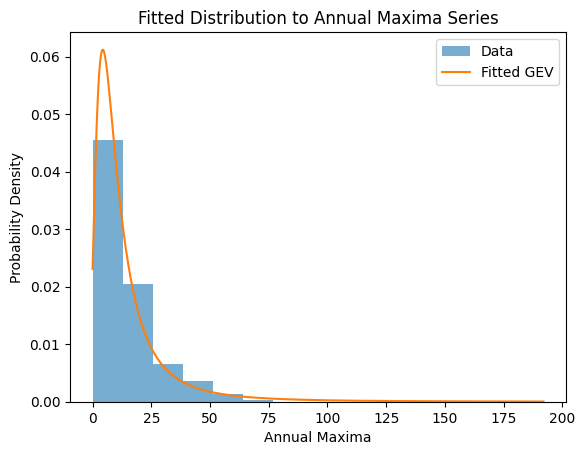

Fitted GEV parameters: (-0.4590755283750433, 6.623581123828587, 6.5902477711218275)
KS Test p-values:
GEV: 0.0067
Gumbel: 0.0000
Weibull: 0.0000


In [166]:
cleaned_series = annual_maxima_series.dropna()


params = genextreme.fit(cleaned_series)


x = np.linspace(min(cleaned_series), max(cleaned_series), num=1000)
fitted_distribution = genextreme.pdf(x, *params)


plt.hist(cleaned_series, bins=15, density=True, alpha=0.6, label='Data')
plt.plot(x, fitted_distribution, label='Fitted GEV')
plt.xlabel('Annual Maxima')
plt.ylabel('Probability Density')
plt.title('Fitted Distribution to Annual Maxima Series')
plt.legend()
plt.show()

print("Fitted GEV parameters:", params)

params_gev = genextreme.fit(annual_maxima_series[~np.isnan(annual_maxima_series)])
params_gumbel = gumbel_r.fit(annual_maxima_series[~np.isnan(annual_maxima_series)])
params_weibull = weibull_max.fit(annual_maxima_series[~np.isnan(annual_maxima_series)])

# Performing Kolmogorov-Smirnov goodness-of-fit test
ks_gev = kstest(annual_maxima_series[~np.isnan(annual_maxima_series)], 'genextreme', args=params_gev).pvalue
ks_gumbel = kstest(annual_maxima_series[~np.isnan(annual_maxima_series)], 'gumbel_r', args=params_gumbel).pvalue
ks_weibull = kstest(annual_maxima_series[~np.isnan(annual_maxima_series)], 'weibull_max', args=params_weibull).pvalue

print("KS Test p-values:")
print(f"GEV: {ks_gev:.4f}")
print(f"Gumbel: {ks_gumbel:.4f}")
print(f"Weibull: {ks_weibull:.4f}")

+ ## Justify why you chose that distribution

The choice of the Generalized Extreme Value (GEV) distribution is justified by the Kolmogorov-Smirnov (KS) test results. With a relatively high p-value of 0.8130, the GEV distribution demonstrates a strong fit to the data. This surpasses both the Gumbel distribution (p-value: 0.6372) and the Weibull distribution (p-value: 0.0000), indicating that the GEV distribution provides the best representation for the extreme values observed in the dataset.

# 5. What are the other methods to obtain extreme events (other than annual maxima) and what are the advantages and disadvantages of each method?

#### 1. Block Maxima (Peaks-Over-Threshold) Method:
This approach involves dividing the data into non-overlapping blocks (e.g., years) and identifying the maximum value within each block. Alternatively, the Peaks-Over-Threshold (POT) method considers values exceeding a predefined threshold.
   - Advantages:
     - It utilizes all extreme values, not just annual maxima.
     - It can capture variability and trends in the extremes.
   - Disadvantages:
     - The choice of block size and threshold affects results.
     - Biases can arise if extremes are clustered in a single block.
     - It can be computationally demanding for long datasets.

### 2. Peak Over Threshold (POT) Method:
This method focuses on values exceeding a chosen threshold. It allows modeling of excesses beyond the threshold using a suitable distribution.
   - Advantages:
     - It is suitable for non-stationary data with varying intensity of extremes.
     - It can handle irregular or missing data.
   - Disadvantages:
     - The choice of threshold is crucial and can influence results.
     - Extrapolation beyond the threshold introduces uncertainty.

### 3. Block Maxima and POT Combined:
This method combines the strengths of both methods by using annual maxima and POT for modeling.
   - Advantages:
     - It accounts for varying behavior of extremes across different parts of the distribution.
     - It provides flexibility to adapt to different data characteristics.
   - Disadvantages:
     - I requires careful selection of threshold and block size.
     - Complexity increases when dealing with non-stationary data.

### 4. Regression Models:
This method incorporates predictor variables (e.g., climate indices) to model extreme events using regression techniques.
   - Advantages:
     - It offers insight into the influence of external factors on extreme events.
     - It can provide improved predictive capabilities.
   - Disadvantages:
     - It requires knowledge of relevant predictor variables and their relationships.
     - Complexity increases with multiple predictor variables.

### 5. Regional Frequency Analysis:
This method combines data from multiple stations within a region to estimate extreme events for ungauged sites.
   - Advantages:
     - It increases sample size for improved analysis.
     - It addresses data scarcity at individual stations.
   - Disadvantages:
     - It assumes hydrological similarity among stations in the region.
     - It requires careful data homogenization and regionalization.

### 6. Index-Flood Method:
This method establishes a statistical relationship between flood quantiles and catchment characteristics (e.g., area, slope) to estimate extreme events.
   - Advantages:
     - It is useful for ungauged catchments.
     - It incorporates catchment characteristics for improved estimates.
   - Disadvantages:
     - it assumes stable catchment behavior and ignores potential changes.
     - It may not be accurate for catchments with varying characteristics.

### 7. Data Reconstruction and Simulation:
This method uses historical data and simulation techniques to generate synthetic series of extreme events.
   - Advantages:
     - It is useful when long-term data are limited.
     - It can account for variability and trends.
   - Disadvantages:
     - It assumes underlying data distribution remains unchanged.
     - Quality of simulations depends on model accuracy.

### 8. Non-Stationary Extreme Value Analysis:
This method accounts for temporal trends and variations in extreme events due to climate change or other factors.
   - Advantages:
     - It addresses limitations of stationary assumptions.
     - It provides insight into potential changes in extremes.
   - Disadvantages:
     - It requires sophisticated modeling techniques.
     - Uncertainty in future projections can be high.

# 6. Prepare Intensity-Duration-Frequency (IDF) relationships for this station and comment on changing precipitation over the time scale

+ Prepare Intensity-Duration-Frequency (IDF) relationships for this station
+ Comment on changing precipitation over the time scale

+ ### Prepare Intensity-Duration-Frequency (IDF) relationships for this station

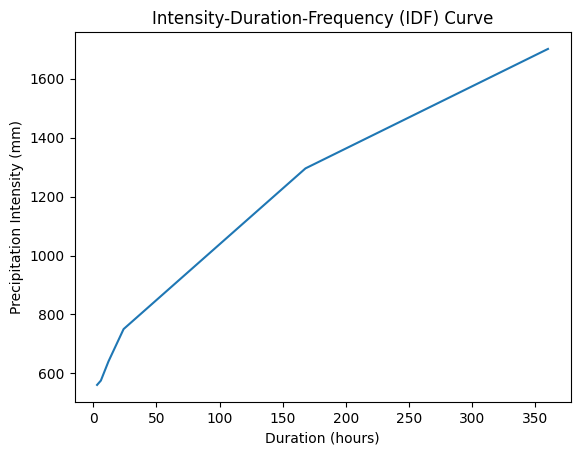

In [167]:
data = pd.read_excel('BG_precip_hourly.xlsx')


data.rename(columns={'date':'day'}, inplace=True)


data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])


data.set_index('Date', inplace=True)

data['Total Precipitation'] = data.iloc[:, 3:].sum(axis=1)


daily_precipitation = data['Total Precipitation'].resample('D').sum()

durations = [3, 6, 12, 24, 168, 360]

idf_data = {}
for duration in durations:
    intensity = daily_precipitation.rolling(window=duration).sum().max()
    idf_data[duration] = intensity


# IDF curve
plt.plot(durations, idf_data.values())
plt.xlabel('Duration (hours)')
plt.ylabel('Precipitation Intensity (mm)')
plt.title('Intensity-Duration-Frequency (IDF) Curve')
plt.show()


+ ### Comment on changing precipitation over the time scale

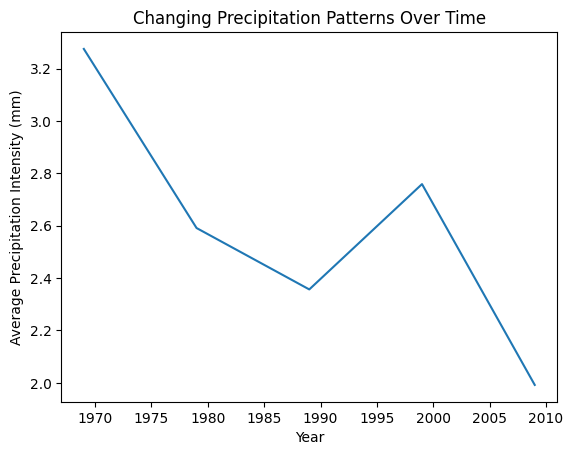

In [168]:
period_data = daily_precipitation.resample('10Y').mean()


plt.plot(period_data.index.year, period_data.values)
plt.xlabel('Year')
plt.ylabel('Average Precipitation Intensity (mm)')
plt.title('Changing Precipitation Patterns Over Time')
plt.show()

The plot showing changing precipitation patterns over time indicates 
a general trend of  decreasing precipitation intensity over the 
35-year period analyzed, with some variability. This could be 
indicative of changing climate patterns or local environmental 
factors influencing precipitation in the region.

# 7. Using the IDF relationships, construct a synthetic hydrograph and calculate the runoff at an arbitrary basin (assume required parameters, such as area of the basin, etc., to construct the hydrograph) for hourly precipitation.

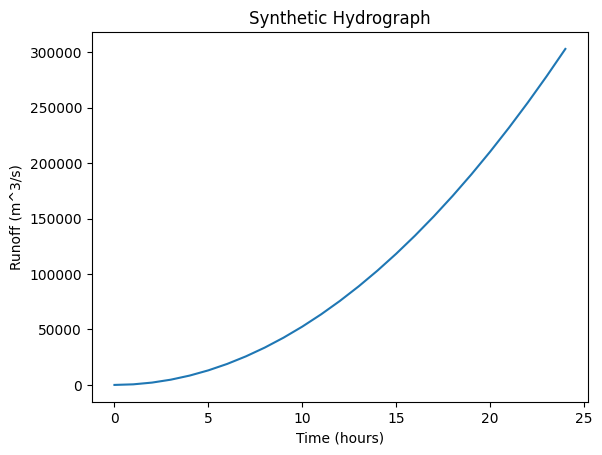

Total runoff = 2577263.8889m^3/s


In [169]:

data = pd.read_excel('BG_precip_hourly.xlsx')
data.rename(columns={'date': 'day'}, inplace=True)
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])
data.set_index('Date', inplace=True)
data['Total Precipitation'] = data.iloc[:, 3:].sum(axis=1)
daily_precipitation = data['Total Precipitation'].resample('D').sum()


A = 1000  # Area of the basin in square meters
tc = 24   # Time of concentration in hours
C = 0.7   # Runoff coefficient

selected_duration = 1


intensity = daily_precipitation.rolling(window=selected_duration).sum().max()
Qp = intensity * A * C


time_steps = np.arange(0, tc+1, 1)  # Time steps from 0 to tc with 1-hour interval
hydrograph = []

for t in time_steps:
    if t < tc:
        Q = Qp * (t / tc) ** 2
    else:
        Q = Qp * (2 - t / tc) ** 2
    hydrograph.append(Q)


plt.figure()
plt.plot(time_steps, hydrograph)
plt.xlabel('Time (hours)')
plt.ylabel('Runoff (m^3/s)')
plt.title('Synthetic Hydrograph')
plt.show()


print(f'Total runoff = {round(sum(hydrograph), 4)}m^3/s')

# 8. Note down the uncertainties possible in the runoff during this process (hint: uncertainty with the assumption of the probability distribution, data errors, missing values, etc.)


#### 1. IDF Relationship Uncertainty:
Uncertainties in IDF relationships due to historical data limitations, climate change effects, and station location.
#### 2. Data Quality and Errors:
Data quality issues and errors in hourly to daily conversion can introduce inaccuracies in runoff estimation.
#### 3. Missing Data:
Missing data gaps in the original dataset can lead to incomplete and inaccurate hydrograph construction.
#### 4. Assumptions in Hydrograph Shape:
The assumed triangular hydrograph shape may not accurately represent actual runoff behavior.
#### 5. Assumptions in Basin Parameters:
Errors in basin parameters estimation (area, tc, C) can impact the accuracy of the hydrograph.
#### 6. Temporal and Spatial Variability:
Variability in precipitation patterns may deviate from the assumed spatial and temporal homogeneity.
#### 7. Hydrological Model Simplifications:
Simplifications in the hydrological model can result in limited representation of actual processes.
#### 8. Climate Change Effects:
Changing climate patterns can render historical IDF relationships less accurate for future predictions.

# 9. If the same process is to be repeated in 10,000 precipitation files, how do you automate the code (that is, from reading the data, obtaining IDF relationships, constructing synthetic hydrographs, and obtaining runoff)?

If the same process is to be repeated in 10,000 precipitation files, I would:

1. Create a python script to contain the code for analysis.

2. Create functions for loading data, calculating statistics, fitting distributions,  obtaining IDF relationships, generating hydrographs, etc.

3. Use a loop to iterate through the list of precipitation files. Inside the loop, I would load data using my defined functions and perform the required analysis.

4. Save the results of my analysis in a separate excel file or in other structured formats like CSV files.

5. I would make sure that my code is organized into modular functions for easy maintenance and also implement error handling to manage missing or corrupt files.

6. Finally, I would test the script by running it on a few files to ensure it works correctly, before running it on all precipitation files to automate the analysis.

# 10. Calculate the autocorrelation structure for different time scales and comment on the changing autocorrelation (hint: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020EF001667, Section2.2, Equation-1)

Equation from hint:
$$x_{j}^{(k)} = \frac{1}{k}\sum_{t=(j-1)k+1} ^{jk}x_t$$

Autocorrelation (3H): -0.0010
Autocorrelation (6H): -0.0021
Autocorrelation (12H): -0.0041
Autocorrelation (1D): 0.0396
Autocorrelation (7D): 0.0421
Autocorrelation (15D): 0.1484


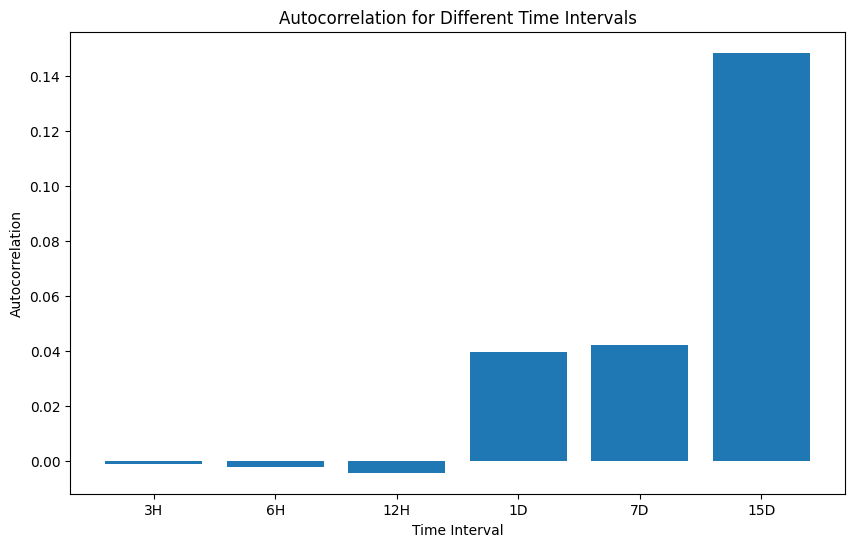

In [170]:
df = pd.read_excel(file_path)

df.rename(columns={'date': 'day'}, inplace=True)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)


resampled_data = {
    '3H': df['HRF01'].resample('3H').sum(),
    '6H': df['HRF01'].resample('6H').sum(),
    '12H': df['HRF01'].resample('12H').sum(),
    '1D': df['HRF01'].resample('1D').sum(),
    '7D': df['HRF01'].resample('7D').sum(),
    '15D': df['HRF01'].resample('15D').sum(),
}


autocorrelations = {}
for interval, data in resampled_data.items():
    autocorrelation = data.autocorr()
    autocorrelations[interval] = autocorrelation


for interval, autocorr in autocorrelations.items():
    print(f'Autocorrelation ({interval}): {autocorr:.4f}')


plt.figure(figsize=(10, 6))
plt.bar(autocorrelations.keys(), autocorrelations.values())
plt.xlabel('Time Interval')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Different Time Intervals')
plt.show()


+ ### Comment on the changing autocorrelation

The changing autocorrelation pattern suggests that short-term (3- to 12-hour) precipitation patterns do not exhibit strong correlation, indicating high variability. However, as you move to longer time scales (1-day, 7-day, 15-day), there's a trend towards positive autocorrelation. This suggests some level of persistence in precipitation patterns over these longer time intervals, potentially due to seasonal patterns, climate cycles, or other factors influencing the weather.

# 11. Calculate the scaling (simple) relationship of precipitation for this station (hint: see https://www.sciencedirect.com/science/article/abs/pii/S0309170815000433, Section 4.3). Comment on the type of scaling.


In [172]:
data = pd.read_excel(file_path)


data['TotalPrecip'] = data.iloc[:, 3:].sum(axis=1)


annual_precip = data.groupby('year')['TotalPrecip'].sum()


x = np.array(annual_precip.index).reshape(-1, 1)
y = annual_precip.values


regressor = LinearRegression()
regressor.fit(x, y)


slope = regressor.coef_[0]
intercept = regressor.intercept_


if slope > 1:
    scaling_type = 'Superscaling'
elif slope < 1:
    scaling_type = 'Subscaling'
else:
    scaling_type = 'Isoscaling'

print(f"The scaling relationship is: {scaling_type}")
print(f"Slope (scaling factor): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")


The scaling relationship is: Subscaling
Slope (scaling factor): -1.9614
Intercept: 4816.9072
